In [1]:
%load_ext autoreload
%autoreload 2
from fastai.vision.all import *
from fastai.distributed import *
from fastai.data import load
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress

from fastai.data.external import untar_data,URLs

from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch
from torch.nn.parallel import DistributedDataParallel

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision.models import resnet50, resnet101

import argparse
from models.utils.joiner_v5 import *
from models.utils.new_losses import *
from models.utils.metrics import *
from models.utils.dataLoader import *
from models.utils.datasets import *
#import webdataset as wds
%reload_ext autoreload

In [2]:
torch.cuda.set_device("cuda:2")

In [9]:
#PARAMETERS
path = Path.home()/'Luiz/gan_attention/data/Custom_ImageNet'


H = 256
W= 256
bs = 5
grid_l = 16
nclass = 4
#backbone = True
#pretrained = True
epochs = 5

beta = 0.00001
gamma = 0.0005
sigma = 1.0

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
])

url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'
url2 = 'https://c.files.bbci.co.uk/4500/production/_119946671_gettyimages-1333150967.jpg'
im = Image.open(requests.get(url, stream=True).raw)
img = transform(im).unsqueeze(0)
im2 = Image.open(requests.get(url2, stream=True).raw)
img2 = transform(im2).unsqueeze(0)
batch= torch.cat((img, img2), 0)

In [4]:
#transform = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
transform = ([*aug_transforms(max_rotate=5.0,max_lighting=0.9),Brightness(max_lighting=0.4),Contrast(max_lighting=0.4),Saturation(max_lighting=0.4),Hue(max_hue=0.2),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

path = untar_data(URLs.CIFAR)
def data_loader(path):
    #transform = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                     get_items=get_image_files, 
                     splitter=RandomSplitter(),
                     get_y=parent_label,
                     item_tfms=Resize(H,W),
                     #batch_tfms=None)
                     batch_tfms=transform)

    dloader = data.dataloaders(path,bs=bs)
    return dloader
dls = data_loader(path)

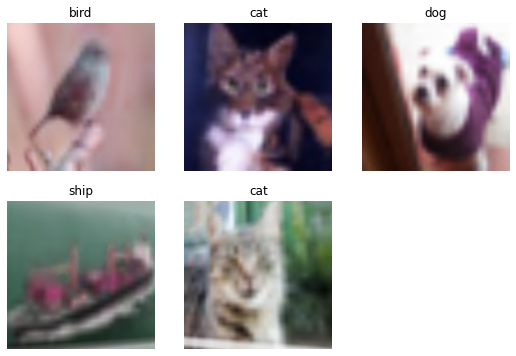

In [5]:
dls.show_batch()

In [6]:
# #Creating the dataloader
# dls = dblock.dataloaders(path/"images", bs=bs)

In [7]:
#dls.train_ds[0][0]
#dls.show_batch()

In [8]:
#Defining the Loss Function
critic_loss = CriticLoss(layer=2, bias=-0.3, beta=beta, sigma=sigma)

In [10]:
#Building the model
model = ImageNetJoiner(num_encoder_layers = 6, nhead=8, num_classes = 10, batch_size=bs, 
               hidden_dim=512, image_h=H, image_w=W, grid_l=grid_l,gm_patch = 32)

In [11]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

10389834

In [12]:
test = model(batch)
len(test)

RuntimeError: shape '[2, 256, 256]' is invalid for input of size 32768

In [10]:
#test[1][0].min()

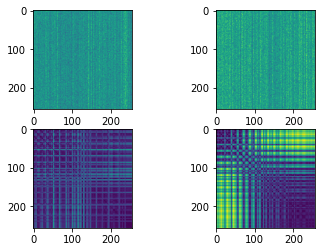

In [11]:
plt.subplot(221)
plt.imshow(test[1][5][0].cpu().detach().numpy())
plt.subplot(222)
plt.imshow(test[1][5][1].cpu().detach().numpy())
plt.subplot(223)
plt.imshow(test[3][0].cpu().detach().numpy())
plt.subplot(224)
plt.imshow(test[3][1].cpu().detach().numpy())

In [12]:
#Wraping the Learner
learner = Learner(dls, model, loss_func=critic_loss, metrics=[Accuracy,AL1])

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.3182567499825382e-06)

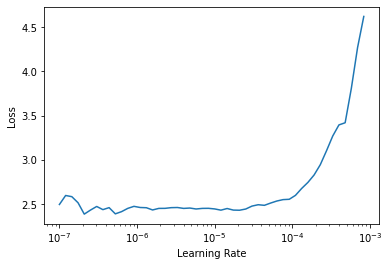

In [13]:
#Finding the best learning rate
learner.lr_find()

In [ ]:
#Fitting the model
learner.fit(1,9e-4)

In [ ]:
model_dir = Path.home()/'Luiz/saved_models'
learner.export(model_dir/'testeRot.pkl')

In [ ]:
def new_empty():  
    return ()
dls.new_empty = new_empty

In [ ]:
model_dir = "../saved_models/"
file_name = "GramImageNet_epochs-"+"20"+"-beta-"+"3e-4"+"_lr-"+"2e-7"+".pkl"
torch.save(learner.model,model_dir+file_name)

In [ ]:
#THE TRAINING LOOP
# model outputs -> [x, sattn, pattn, inputs, x0]

running_loss_history = [] # training loss - to generate a plot
running_acc_history = [] # traning accuracy
running_latt_history = [] # traning accuracy

val_running_loss_history = [] # validation loss
val_running_acc_history = [] # validation accuracy

for e in range(epochs):
  
    start_time = time.time()
    print('Epoch {}/{}'.format(e+1, epochs))
    print('-' * 10)

    running_loss = 0.0
    running_acc = 0.0
    running_latt = 0.0
    
    val_running_loss = 0.0
    val_running_acc = 0.0
    
    batch=0
    
    for inputs, labels in train_loader:
        
        batch+=1
        sys.stdout.write('\rBatch: %d' %batch)
        sys.stdout.flush()

        #TRAINING
        inputs = inputs.to(device) # allow gpu use
        labels[0] = labels[0].to(device)
        labels[1] = labels[1].to(device)# allow gpu use
        outputs = model(inputs) #gives the output of the last layer
        loss = train_loss(outputs, labels) # comparing outputs and labels using the criteria
        
        optimizer.zero_grad() #zero the grad
        loss.backward() #backpropagation
        optimizer.step() #optimize weights 

        #COMPUTING TRAINING METRICS
        acc = Accuracy(outputs,labels)
        latt = Curating_Of_Attention_Loss(outputs,labels)
        
        running_loss += loss.item() # the sum of the loss of all itens
        running_acc += acc
        running_latt += latt
        
        Typenone = 0
        zeros = 0
        normal = 0
        for name, param in model.named_parameters():
            if param.grad == None:
                Typenone +=1
            elif torch.sum(param.grad) == 0:
                zeros += 1
            else:
                normal += 1
        if Typenone >10:
            print("None parameters:",Typenone)
            for name, param in model.named_parameters():
                if param.grad == None:
                    print(name)
        if zeros > 5:
            print("Zero Grad Parameters:", zeros)
        #print("Normally computed Parameters:",normal)
                
                
    else:
        #VALIDATION
        with torch.no_grad(): # to save memory (temporalely set all the requires grad to be false)
            for val_inputs, val_labels in valid_loader:
                val_inputs = val_inputs.to(device) # allow gpu use
                val_labels = val_labels.to(device) # allow gpu use
                val_outputs = model(val_inputs) #passes the image through the network and get the output
                val_loss = valid_loss(val_outputs, val_labels) #compare output and labels to get the loss 

                val_acc = Accuracy(val_outputs,val_labels)
                val_running_loss += val_loss.item() #same as for training
                val_running_acc += val_acc
                
    #Adding one step to the optimizer            
    model_lr_scheduler.step()
    
    #TRAINING LOSS AND ACCURACY
    epoch_loss = running_loss/len(train_ds) # the sum of the loss of all itens divided by the number of itens
    epoch_acc = running_acc/len(train_loader) # the sum of correct predictions divided by the number of itens
    epoch_latt = running_latt/len(train_loader)
    
    running_loss_history.append(epoch_loss) #append to respective list
    running_acc_history.append(epoch_acc) #append to respective list
    running_latt_history.append(epoch_latt) #append to respective list

    #VALIDATION LOSS AND ACCURACY
    val_epoch_loss = val_running_loss/len(valid_ds)
    val_epoch_acc = val_acc/ len(valid_loader)
    
    val_running_loss_history.append(val_epoch_loss) #append to respective list
    val_running_acc_history.append(val_epoch_acc) #append to respective list
    
    
    epoch_time_elapsed = time.time() - start_time
    print('Epoch training complete in {:.0f}m {:.0f}s'.format(
            epoch_time_elapsed // 60, epoch_time_elapsed % 60))
    print('training loss: {:.4f}, acc {:.4f}, noised acc {:.4f} '.format(epoch_loss, epoch_acc.item(), epoch_noised_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))